In [1]:
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_mpl_presets, append_axes
from scipy.stats import bootstrap, skewnorm, linregress
from scipy.optimize import curve_fit, bisect
from scipy.integrate import quad
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.colors as mplcolors
import matplotlib.cm as cmx
import numpy as np
import warnings
import random
import vice
import sys
load_mpl_presets()
# warnings.filterwarnings("ignore")
print(sys.version_info)

sys.version_info(major=3, minor=10, micro=2, releaselevel='final', serial=0)


/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
columns = ["LINE", "APOGEE_ID", "RA", "DEC", "GALR", "GALPHI", "GALZ", "SNREV", "TEFF", "TEFF_ERR",
    "LOGG", "LOGG_ERR", "FE_H", "FE_H_ERR", "O_FE", "O_FE_ERR", "ASTRONN_AGE", "ASTRONN_AGE_ERR",
    "LATENT_AGE", "LATENT_AGE_ERR"]
raw = np.genfromtxt("../data/Leung2023.csv", delimiter = ',', skip_header = 1, usecols = range(len(columns)))
sample = {}
for i in range(len(columns)):
    sample[columns[i]] = [row[i] for row in raw]
sample["o_h"] = [a + b for a, b in zip(sample["O_FE"], sample["FE_H"])]
sample["o_h_err"] = [np.sqrt(a**2 + b**2) for a, b in zip(sample["O_FE_ERR"], sample["FE_H_ERR"])]
sample["absz"] = [abs(_) for _ in sample["GALZ"]]
sample = vice.dataframe(sample)
print(sample)

vice.dataframe{
    line -----------> [0, 1, 2, ... , 192917, 192918, 192919]
    apogee_id ------> [nan, nan, nan, ... , nan, nan, nan]
    ra -------------> [0.00285, 0.005558, 0.008802, ... , 359.993, 359.995, 359.997]
    dec ------------> [57.1732, 57.3545, 63.4631, ... , 57.0124, 57.435, 56.1633]
    galr -----------> [8.4584, 11.9539, 12.8583, ... , 10.6942, 9.3281, 9.64501]
    galphi ---------> [175.658, 153.655, 151.397, ... , 159.022, 167.511, 165.095]
    galz -----------> [-0.040749, -0.470835, 0.169356, ... , -0.358826, -0.163006, -0.265258]
    snrev ----------> [282.746, 120.295, 169.02, ... , 101.537, 232.918, 88.4561]
    teff -----------> [5031.26, 4974.6, 4681.46, ... , 4954.17, 4859.91, 4585.41]
    teff_err -------> [10.1451, 15.3109, 8.76634, ... , 15.7503, 9.05073, 11.2989]
    logg -----------> [3.45613, 2.38825, 2.24553, ... , 2.47466, 2.48069, 2.57144]
    logg_err -------> [0.0235541, 0.0355173, 0.0243345, ... , 0.0347484, 0.0240131, 0.0286862]
    fe_h ----

In [3]:
class line:
    
    def __init__(self, slope, intercept):
        self.slope = slope
        self.intercept = intercept
        
    def __call__(self, x):
        return self.slope * x + self.intercept

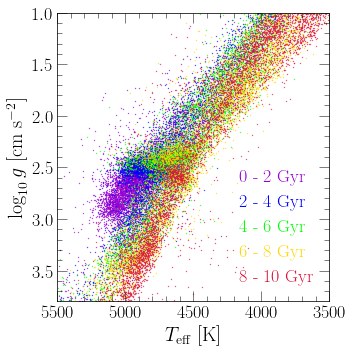

In [15]:
N_SAMPLE = 5000
random.seed(a = 1)

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$T_\text{eff}$ [K]")
ax.set_ylabel(r"$\log_{10} g$ [cm s$^{-2}$]")
ax.set_xlim([3500, 5500])
ax.set_ylim([1, 3.8])
ax.invert_xaxis()
ax.invert_yaxis()


age_bins = [0, 2, 4, 6, 8, 10]
colors = ["darkviolet", "blue", "lime", "gold", "crimson"]
for i in range(len(colors)):
    subsample = sample.filter(
        "ASTRONN_AGE", ">=", age_bins[i]).filter(
        "ASTRONN_AGE", "<=", age_bins[i + 1]).filter(
        "ABSZ", ">=", 0).filter(
        "ABSZ", "<=", 0.5)
    indices = random.sample(range(len(subsample["TEFF"])), N_SAMPLE)
    kwargs = {
        "c": named_colors()[colors[i]],
        "s": 0.1,
        "rasterized": True,
        "label": "%d - %d Gyr" % (age_bins[i], age_bins[i + 1])
    }
    teff = [subsample["TEFF"][idx] for idx in indices]
    logg = [subsample["LOGG"][idx] for idx in indices]
    ax.scatter(teff, logg, **kwargs)

# kwargs = {
#     "c": named_colors()["black"],
#     "linestyle": "--"
# }
# ax.plot([4250, ax.get_xlim()[0]], 2 * [2.5], **kwargs)
# ax.plot([4250, ax.get_xlim()[0]], 2 * [3.6], **kwargs)
    
kwargs = {
    "loc": mpl_loc("lower right"),
    "ncol": 1,
    "handlelength": 0
}
leg = ax.legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
plt.savefig("../paper/figures/kiel_diagram.pdf")
plt.show()

x = 12.00     
x = 1.00      
x = 1.00      
x = 12.00     
x = 1.00      
x = 1.00      
x = 12.00     
x = 1.00      
x = 1.00      
x = 12.00     
x = 1.00      
x = 1.00      
x = 12.00     
x = 1.00      
x = 1.00      
x = 12.00     
x = 1.00      
x = 1.00      


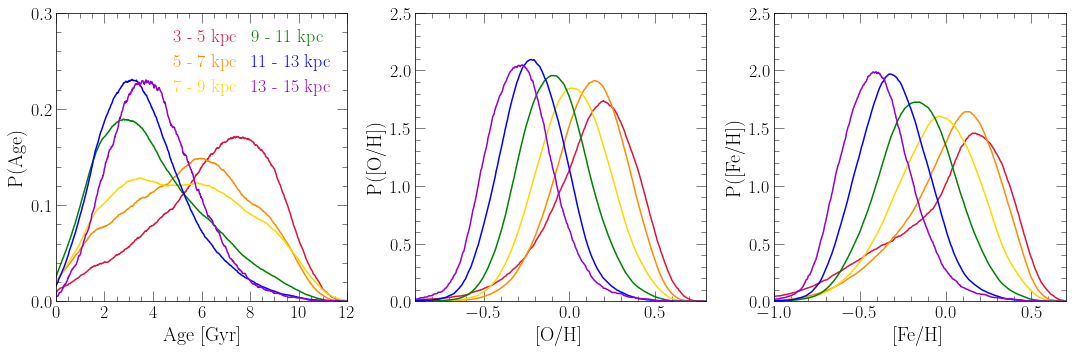

In [6]:
fig = plt.figure(figsize = (15, 5))
axes = []
for i in range(3):
    axes.append(fig.add_subplot(131 + i))
axes[0].set_xlabel(r"Age [Gyr]")
axes[0].set_ylabel(r"P(Age)")
axes[0].set_xlim([0, 12])
axes[0].set_xticks([0, 2, 4, 6, 8, 10, 12])
axes[0].set_ylim([0, 0.3])
axes[0].set_yticks([0, 0.1, 0.2, 0.3])
axes[1].set_xlabel(r"[O/H]")
axes[1].set_ylabel(r"P([O/H])")
axes[1].set_xlim([-0.9, 0.8])
axes[1].set_ylim([0, 2.5])
axes[2].set_xlabel(r"[Fe/H]")
axes[2].set_ylabel(r"P([Fe/H])")
axes[2].set_xlim([-1, 0.7])
axes[2].set_ylim([0, 2.5])

radial_bins = [3, 5, 7, 9, 11, 13, 15]
colors = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]

# age_bins = np.linspace(0, 11, 40)
# xh_bins = np.linspace(-2, 1, 100)
age_vals = np.linspace(0, 12, 1000)
xh_vals = np.linspace(-2, 1, 1000)

def boxcarsmoothdist(data, xcoords, window):
    yvals = len(xcoords) * [0.]
    for i in range(len(xcoords)):
        sys.stdout.write("\rx = %.2f     " % (xcoords[i]))
        for j in range(len(data)):
            if xcoords[i] - window <= data[j] <= xcoords[i] + window: yvals[i] += 1
    sys.stdout.write("\n")
    norm = sum(yvals) * (xcoords[1] - xcoords[0])
    for i in range(len(yvals)): yvals[i] /= norm
#     for i in range(len(yvals)): yvals[i] /= window
    return yvals

for i in range(len(radial_bins) - 1):
    subsample = sample.filter(
        "GALR", ">=", radial_bins[i]).filter(
        "GALR", "<=", radial_bins[i + 1]).filter(
        "ABSZ", ">=", 0).filter(
        "ABSZ", "<=", 0.5)
    
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": "%d - %d kpc" % (radial_bins[i], radial_bins[i + 1])
    }

    dist = boxcarsmoothdist(subsample["ASTRONN_AGE"], age_vals, 1)
    axes[0].plot(age_vals, dist, **kwargs)
    
    dist = boxcarsmoothdist(subsample["O_H"], xh_vals, 0.2)
    axes[1].plot(xh_vals, dist, **kwargs)
    
    dist = boxcarsmoothdist(subsample["FE_H"], xh_vals, 0.2)
    axes[2].plot(xh_vals, dist, **kwargs)
#     dist, _ = np.histogram(subsample["ASTRONN_AGE"], bins = age_bins, density = True)
#     axes[0].step(age_bins[:-1], dist, where = "post", **kwargs)
    
#     dist, _ = np.histogram(subsample["O_H"], bins = xh_bins, density = True)
#     axes[1].step(xh_bins[:-1], dist, where = "post", **kwargs)
    
#     dist, _ = np.histogram(subsample["FE_H"], bins = xh_bins, density = True)
#     axes[2].step(xh_bins[:-1], dist, where = "post", **kwargs)
    
kwargs = {
    "loc": mpl_loc("upper right"),
    "ncol": 2,
    "handlelength": 0,
    "columnspacing": 0.5
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
plt.savefig("../paper/figures/age_xh_dists.pdf")
plt.show()

Slope: -0.375 +/- 0.036
Intercept: 8.213 +/- 0.313
r^2 = 0.892


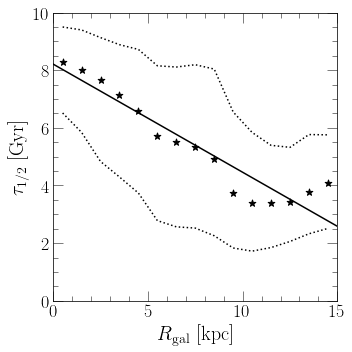

In [5]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
ax.set_ylabel(r"$\tau_{1/2}$ [Gyr]")
ax.set_xlim([0, 15])
ax.set_ylim([0, 10])

AGE_KEY = "ASTRONN_AGE"
radial_bins = list(range(16))
subsample = sample.filter(
    "GALZ", ">=", -0.5).filter(
    "GALZ", "<=", 0.5).filter(
    AGE_KEY, ">=", 0)
radii = []
medians = []
lowers = []
uppers = []
for i in range(len(radial_bins) - 1):
    subsubsample = subsample.filter(
        "GALR", ">=", radial_bins[i]).filter(
        "GALR", "<=", radial_bins[i + 1])
    if len(subsubsample[AGE_KEY]) > 200:
        radii.append((radial_bins[i] + radial_bins[i + 1]) / 2)
        medians.append(np.median(subsubsample[AGE_KEY]))
        sorted_ages = np.sort(subsubsample[AGE_KEY])
        lowers.append(sorted_ages[int(0.16 * len(sorted_ages))])
        uppers.append(sorted_ages[int(0.84 * len(sorted_ages))])
    else:
        pass

ax.scatter(radii, medians, c = named_colors()["black"], marker = markers()["star"], s = 50)
ax.plot(radii, lowers, c = named_colors()["black"], linestyle = ":")
ax.plot(radii, uppers, c = named_colors()["black"], linestyle = ":")

fit = linregress(radii, medians)
print("Slope: %.3f +/- %.3f" % (fit.slope, fit.stderr))
print("Intercept: %.3f +/- %.3f" % (fit.intercept, fit.intercept_stderr))
print("r^2 = %.3f" % (fit.rvalue**2))

bestfit = line(fit.slope, fit.intercept)
ax.plot(ax.get_xlim(), [bestfit(_) for _ in ax.get_xlim()],
    c = named_colors()["black"], linestyle = "-")

plt.tight_layout()
plt.savefig("../paper/figures/age_gradient.pdf")
plt.show()

In [2]:
def skewnormal(x, a, mean, std):
    return 1 / std * skewnorm.pdf((x - mean) / std, a)

def skewnormal_estimate_mode(a, mean, std):
    r"""See notes in apogee.ipynb"""
    delta = a / np.sqrt(1 + a**2)
    term1 = (4 - np.pi) / 2 * delta**3 / (np.pi - 2 * delta**2)
    sgn = int(a > 0) - int(a < 0)
    factor = np.sqrt(2 / np.pi) * (delta - term1) - sgn / 2 * np.exp(-2 * np.pi / abs(a))
    return mean + std * factor

def skewnormal_mode_sample(sample, bins = np.linspace(-3, 2, 1001), axis = 1):
    centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    dist, _ = np.histogram(sample, bins = bins, density = True)
    opt, cov = curve_fit(skewnormal, centers, dist, p0 = [1, 0, 1])
    return np.array([skewnormal_estimate_mode(opt[0], opt[1], opt[2])])

def skewnormal_mode_sample_bootstrap(sample, bins = np.linspace(-3, 2, 1001)):
    centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    mode = skewnormal_mode_sample(sample, bins = bins)
    bootstrap_ci = bootstrap((sample,), skewnormal_mode_sample, confidence_level = 0.68,
        method = "percentile", random_state = 1)
    minus_err = mode - bootstrap_ci.confidence_interval.low
    plus_err = bootstrap_ci.confidence_interval.high - mode
    return np.array([mode, minus_err, plus_err])

In [29]:
subsample = sample.filter(
    "GALR", ">=", 8).filter(
    "GALR", "<=", 10).filter(
    "GALZ", ">=", -0.5).filter(
    "GALZ", "<=", 0.5)
print(len(subsample["O_H"]))
print(skewnormal_mode_sample(subsample["O_H"]))

36375
[-0.0506427]


In [30]:
radial_bins = list(range(16))
bins = np.linspace(-3, 2, 1001)
# centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
with open("./paperfigures/gradient_fit.out", "w") as f:
    f.write("# r_min [kpc]    r_max [kpc]    oh_16th    mode_oh    err_mode_oh_minus    ")
    f.write("err_mode_oh_plus    oh_84th    feh_16th    mode_feh    err_mode_feh_minus    ")
    f.write("err_mode_feh_plus    feh_84th\n")
    for i in range(len(radial_bins) - 1):
        sys.stdout.write("\rR = %d - %d kpc     " % (radial_bins[i], radial_bins[i + 1]))
        subsample = sample.filter(
            "GALR", ">=", radial_bins[i]).filter(
            "GALR", "<=", radial_bins[i + 1]).filter(
            "GALZ", ">=", -0.5).filter(
            "GALZ", "<=", 0.5)
        f.write("%.3e\t%.3e\t" % (radial_bins[i], radial_bins[i + 1]))
        if len(subsample["O_H"]) >= 200:
            mode_oh, minus_oh, plus_oh = skewnormal_mode_sample_bootstrap(subsample["O_H"])
            sorted_oh = np.sort(subsample["O_H"])
            oh_16th = sorted_oh[int(0.16 * len(sorted_oh))]
            oh_84th = sorted_oh[int(0.84 * len(sorted_oh))]

            mode_feh, minus_feh, plus_feh = skewnormal_mode_sample_bootstrap(subsample["FE_H"])
            sorted_feh = np.sort(subsample["FE_H"])
            feh_16th = sorted_feh[int(0.16 * len(sorted_feh))]
            feh_84th = sorted_feh[int(0.84 * len(sorted_feh))]
            
            f.write("%.3e\t%.3e\t%.3e\t%.3e\t%.3e\t" % (oh_16th, mode_oh, minus_oh, plus_oh, oh_84th))
            f.write("%.3e\t%.3e\t%.3e\t%.3e\t%.3e\n" % (feh_16th, mode_feh, minus_feh, plus_feh, feh_84th))
            
        else:
            for i in range(10): f.write("nan\t")
            f.write("\n")
    sys.stdout.write("\n")
    f.close()

R = 0 - 1 kpc     

/Users/astrobeard/anaconda3/envs/py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/astrobeard/anaconda3/envs/py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


R = 14 - 15 kpc     


Oyxgen
Slope: -0.062 +/- 0.001
Intercept: 0.524 +/- 0.013
chi^2: 3.970e-03
R^2: 0.993
p: 3.225e-15

Iron
Slope: -0.070 +/- 0.003
Intercept: 0.541 +/- 0.026
chi^2: 2.342e-02
R^2: 0.976
p: 5.907e-12


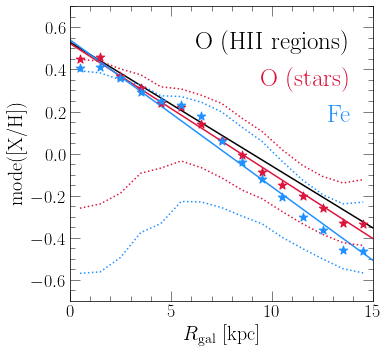

In [5]:
fig = plt.figure(figsize = (5.5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
ax.set_ylabel(r"mode([X/H])")
ax.set_xlim([0, 15])
ax.set_ylim([-0.7, 0.7])

slope = -0.059
intercept = np.log10(vice.solar_z.epsilon_to_z_conversion(9.22, 15.999) / vice.solar_z['o'])
hii_regions = line(slope, intercept)
kwargs = {
    "c": named_colors()["black"],
    "label": "O (HII regions)"
}
ax.plot(ax.get_xlim(), [hii_regions(_) for _ in ax.get_xlim()], **kwargs)

fitraw = np.genfromtxt("./paperfigures/gradient_fit.out")
rmin = fitraw[:,0]
rmax = fitraw[:,1]
oh_16th = fitraw[:,2]
oh_mode = fitraw[:,3]
oh_minuserr = fitraw[:,4]
oh_pluserr = fitraw[:,5]
oh_84th = fitraw[:,6]
feh_16th = fitraw[:,7]
feh_mode = fitraw[:,8]
feh_minuserr = fitraw[:,9]
feh_pluserr = fitraw[:,10]
feh_84th = fitraw[:,11]
radii = [(a + b) / 2 for a, b in zip(rmin, rmax)]

def chi_squared(radii, xh, regression):
    chisq = 0
    bestfit = line(regression.slope, regression.intercept)
    for i in range(len(radii)):
        expected = abs(bestfit(radii[i]))
        observed = abs(xh[i])
        chisq += (observed - expected)**2 / expected
#         x = (observed - expected)**2 / expected
#         print(observed, expected, x)
#         chisq += x
    chisq /= (len(radii) - 2) # 2 degrees of freedom for a line
    return chisq

oh_regress = linregress(radii, oh_mode)
feh_regress = linregress(radii, feh_mode)

print("Oyxgen")
print("======")
print("Slope: %.3f +/- %.3f" % (oh_regress.slope, oh_regress.stderr))
print("Intercept: %.3f +/- %.3f" % (oh_regress.intercept, oh_regress.intercept_stderr))
print("chi^2: %.3e" % (chi_squared(radii, oh_mode, oh_regress)))
print("R^2: %.3f" % (oh_regress.rvalue**2))
print("p: %.3e" % (oh_regress.pvalue))
print("")
print("Iron")
print("======")
print("Slope: %.3f +/- %.3f" % (feh_regress.slope, feh_regress.stderr))
print("Intercept: %.3f +/- %.3f" % (feh_regress.intercept, feh_regress.intercept_stderr))
print("chi^2: %.3e" % (chi_squared(radii, feh_mode, feh_regress)))
print("R^2: %.3f" % (feh_regress.rvalue**2))
print("p: %.3e" % (feh_regress.pvalue))

kwargs = {
    "c": named_colors()["crimson"],
    "label": "O (stars)"
}
oh_grad = line(oh_regress.slope, oh_regress.intercept)
ax.plot(ax.get_xlim(), [oh_grad(_) for _ in ax.get_xlim()], **kwargs)
kwargs["c"] = named_colors()["dodgerblue"]
kwargs["label"] = "Fe"
feh_grad = line(feh_regress.slope, feh_regress.intercept)
ax.plot(ax.get_xlim(), [feh_grad(_) for _ in ax.get_xlim()], **kwargs)

kwargs = {
    "c": named_colors()["crimson"],
    "marker": markers()["star"],
    "s": 80,
    "zorder": 10
}
ax.scatter(radii, oh_mode, **kwargs)
kwargs["c"] = named_colors()["dodgerblue"]
ax.scatter(radii, feh_mode, **kwargs)

kwargs = {
    "c": named_colors()["crimson"],
    "linestyle": ':'
}
ax.plot(radii, oh_16th, **kwargs)
ax.plot(radii, oh_84th, **kwargs)
kwargs = {
    "c": named_colors()["dodgerblue"],
    "linestyle": ':'
}
ax.plot(radii, feh_16th, **kwargs)
ax.plot(radii, feh_84th, **kwargs)

kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 0,
    "fontsize": 25
}
leg = ax.legend(**kwargs)
fancy_legend(leg, ["black", "crimson", "dodgerblue"])
renderer = fig.canvas.get_renderer()
width = max([t.get_window_extent(renderer).width for t in leg.get_texts()])
for t in leg.get_texts():
    t.set_ha("right")
    shift = width - t.get_window_extent(renderer).width
    t.set_position((shift, 0))

plt.tight_layout()
plt.savefig("../paper/figures/gradxh.pdf")
plt.show()

In [29]:
def skewnormal(x, a, mean, std):
    return 1 / std * skewnorm.pdf((x - mean) / std, a)

# age_bins = list(range(0, 11, 2))
age_bins = list(range(11))
radial_bins = list(range(16))
midplane_sample = sample.filter(
    "GALZ", ">=", -0.5).filter(
    "GALZ", "<=", 0.5).filter(
    "O_H", ">=", -10).filter(
    "O_H", "<=", 10).filter(
    "FE_H", ">=", -10).filter(
    "FE_H", "<=", 10)
with open("./paperfigures/age_gradoh_skewnormfits.out", "w") as f_oh:
    with open("./paperfigures/age_gradfeh_skewnormfits.out", "w") as f_fe:
        for f in [f_oh, f_fe]:
            f.write("# age_min [Gyr]    age_max [Gyr]    ")
            f.write("r_min [Gyr]    r_max [Gyr]    ")
            f.write("xh_mode    xh_mode_minuserr    xh_mode_pluserr\n")
        for i in range(len(age_bins) - 1):
            subsample = midplane_sample.filter(
                "ASTRONN_AGE", ">=", age_bins[i]).filter(
                "ASTRONN_AGE", "<=", age_bins[i + 1])
            for j in range(len(radial_bins) - 1):
                for f in [f_oh, f_fe]: f.write("%.3e\t%.3e\t" % (age_bins[i], age_bins[i + 1]))
                for f in [f_oh, f_fe]: f.write("%.3e\t%.3e\t" % (radial_bins[j], radial_bins[j + 1]))
#                 sys.stdout.write("\rAge: %d - %d Gyr ; Radius: %d - %d kpc           " % (
#                     age_bins[i], age_bins[i + 1], radial_bins[j], radial_bins[j + 1]))
                subsubsample = subsample.filter(
                    "GALR", ">=", radial_bins[j]).filter(
                    "GALR", "<=", radial_bins[j + 1])
                print("Age: %d - %d Gyr ; Radius: %d - %d kpc ; Nstars = %d" % (
                    age_bins[i], age_bins[i + 1], radial_bins[j], radial_bins[j + 1],
                    len(subsubsample["GALR"])))
                if len(subsubsample["O_H"]) > 200:
                    bins = np.linspace(-2, 2, 101)
                    mode_oh, minus_oh, plus_oh = skewnormal_mode_sample_bootstrap(subsubsample["O_H"])
                    f_oh.write("%.3e\t%.3e\t%.3e\t" % (mode_oh, minus_oh, plus_oh))
                    
                    mode_feh, minus_feh, plus_feh = skewnormal_mode_sample_bootstrap(subsubsample["FE_H"])
                    f_fe.write("%.3e\t%.3e\t%.3e\t" % (mode_feh, minus_feh, plus_feh))
                else:
                    for f in [f_oh, f_fe]:
                        for _ in range(3): f.write("nan\t")
                for f in [f_oh, f_fe]: f.write("\n")
        f_fe.close()
    f_oh.close()
    sys.stdout.write("\n")

Age: 0 - 1 Gyr ; Radius: 0 - 1 kpc ; Nstars = 4
Age: 0 - 1 Gyr ; Radius: 1 - 2 kpc ; Nstars = 11
Age: 0 - 1 Gyr ; Radius: 2 - 3 kpc ; Nstars = 22
Age: 0 - 1 Gyr ; Radius: 3 - 4 kpc ; Nstars = 44
Age: 0 - 1 Gyr ; Radius: 4 - 5 kpc ; Nstars = 64
Age: 0 - 1 Gyr ; Radius: 5 - 6 kpc ; Nstars = 192
Age: 0 - 1 Gyr ; Radius: 6 - 7 kpc ; Nstars = 352


/Users/astrobeard/anaconda3/envs/py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/astrobeard/anaconda3/envs/py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Age: 0 - 1 Gyr ; Radius: 7 - 8 kpc ; Nstars = 442
Age: 0 - 1 Gyr ; Radius: 8 - 9 kpc ; Nstars = 725
Age: 0 - 1 Gyr ; Radius: 9 - 10 kpc ; Nstars = 872
Age: 0 - 1 Gyr ; Radius: 10 - 11 kpc ; Nstars = 666
Age: 0 - 1 Gyr ; Radius: 11 - 12 kpc ; Nstars = 273
Age: 0 - 1 Gyr ; Radius: 12 - 13 kpc ; Nstars = 73
Age: 0 - 1 Gyr ; Radius: 13 - 14 kpc ; Nstars = 11
Age: 0 - 1 Gyr ; Radius: 14 - 15 kpc ; Nstars = 4
Age: 1 - 2 Gyr ; Radius: 0 - 1 kpc ; Nstars = 7
Age: 1 - 2 Gyr ; Radius: 1 - 2 kpc ; Nstars = 14
Age: 1 - 2 Gyr ; Radius: 2 - 3 kpc ; Nstars = 29
Age: 1 - 2 Gyr ; Radius: 3 - 4 kpc ; Nstars = 64
Age: 1 - 2 Gyr ; Radius: 4 - 5 kpc ; Nstars = 133
Age: 1 - 2 Gyr ; Radius: 5 - 6 kpc ; Nstars = 291
Age: 1 - 2 Gyr ; Radius: 6 - 7 kpc ; Nstars = 608
Age: 1 - 2 Gyr ; Radius: 7 - 8 kpc ; Nstars = 824
Age: 1 - 2 Gyr ; Radius: 8 - 9 kpc ; Nstars = 1674
Age: 1 - 2 Gyr ; Radius: 9 - 10 kpc ; Nstars = 2465
Age: 1 - 2 Gyr ; Radius: 10 - 11 kpc ; Nstars = 2022
Age: 1 - 2 Gyr ; Radius: 11 - 12 kpc ; Nst

Oxygen
Age: 0 - 1 Gyr
Slope: -0.055 +/- 0.011
Intercept: 0.459 +/- 0.103
chi^2: 1.458e-01
r^2: 0.859
p: 7.892e-03
----------------------
Age: 1 - 2 Gyr
Slope: -0.056 +/- 0.005
Intercept: 0.473 +/- 0.048
chi^2: 8.170e-02
r^2: 0.951
p: 3.852e-05
----------------------
Age: 2 - 3 Gyr
Slope: -0.059 +/- 0.005
Intercept: 0.497 +/- 0.052
chi^2: 1.289e-01
r^2: 0.947
p: 9.880e-06
----------------------
Age: 3 - 4 Gyr
Slope: -0.066 +/- 0.004
Intercept: 0.544 +/- 0.038
chi^2: 1.688e-01
r^2: 0.972
p: 1.803e-07
----------------------
Age: 4 - 5 Gyr
Slope: -0.079 +/- 0.004
Intercept: 0.662 +/- 0.037
chi^2: 5.503e-02
r^2: 0.980
p: 4.029e-08
----------------------
Age: 5 - 6 Gyr
Slope: -0.080 +/- 0.007
Intercept: 0.690 +/- 0.062
chi^2: 9.260e-02
r^2: 0.937
p: 4.365e-06
----------------------
Age: 6 - 7 Gyr
Slope: -0.055 +/- 0.008
Intercept: 0.515 +/- 0.062
chi^2: 2.247e-01
r^2: 0.850
p: 1.495e-04
----------------------
Age: 7 - 8 Gyr
Slope: -0.049 +/- 0.002
Intercept: 0.517 +/- 0.015
chi^2: 3.196e-01


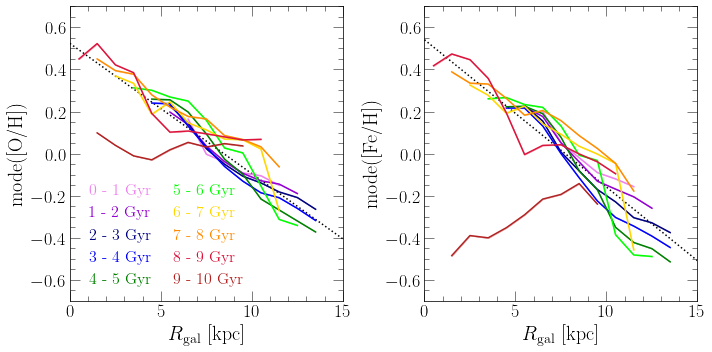

In [26]:
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for ax in [ax1, ax2]:
    ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
    ax.set_xlim([0, 15])
    ax.set_ylim([-0.7, 0.7])
ax1.set_ylabel(r"mode([O/H])")
ax2.set_ylabel(r"mode([Fe/H])")
axes = [ax1, ax2]
random.seed(a = 1)

age_bins = list(range(11))
# age_bins = list(range(0, 11, 2))
radial_bins = list(range(16))
colors = ["violet", "darkviolet", "navy", "blue", "green", "lime", "gold", "darkorange", "crimson", "firebrick"]
# colors = ["darkviolet", "blue", "green", "darkorange", "crimson"]
# colors = ["purple", "blue", "lime", "crimson", "black"]

for i, regression in enumerate([oh_regress, feh_regress]):
    bestfit = line(regression.slope, regression.intercept)
    kwargs = {
        "c": named_colors()["black"],
        "linestyle": ":"
    }
    axes[i].plot(axes[i].get_xlim(), [bestfit(_) for _ in   axes[i].get_xlim()], **kwargs)

filenames = ["./paperfigures/age_gradoh_skewnormfits.out", "./paperfigures/age_gradfeh_skewnormfits.out"]
oh_slopes = []
feh_slopes = []
for ax_idx, file in enumerate(filenames):
    print(["Oxygen", "Iron"][ax_idx])
    print("===============")
    raw = np.genfromtxt(file)
    for i in range(len(age_bins) - 1):
        fits = raw[i * (len(radial_bins) - 1) : (i + 1) * (len(radial_bins) - 1)]
        radii = []
        xh = []
        xh_minus_err = []
        xh_plus_err = []
        for j in range(len(fits)):
            if not any([np.isnan(_) for _ in fits[j]]):
                radii.append((fits[j][2] + fits[j][3]) / 2)
                xh.append(fits[j][4])
                xh_minus_err.append(fits[j][5])
                xh_plus_err.append(fits[j][6])
            else: pass
        kwargs = {
            "c": named_colors()[colors[i]],
            "label": r"%d - %d Gyr" % (age_bins[i], age_bins[i + 1])
        }
        axes[ax_idx].plot(radii, xh, **kwargs)
        axes[ax_idx].fill_between(radii, [a - b for a, b in zip(xh, xh_minus_err)],
            [a + b for a, b in zip(xh, xh_plus_err)], alpha = 0.3, color = kwargs["c"])
        regression = linregress(radii, xh)
#         print("$%d - %d$ Gyr & $%.3f \pm %.3f$ kpc$^{-1}$ & $%.3f \pm %.3f$ & $%.3f$" % (
#             age_bins[i], age_bins[i + 1],
#             regression.slope, regression.stderr,
#             regression.intercept, regression.intercept_stderr,
#             chi_squared(radii, xh, [oh_regress, feh_regress][ax_idx])))
#         print(r"\\")
        [oh_slopes, feh_slopes][ax_idx].append([regression.slope, regression.stderr])
        print("Age: %d - %d Gyr" % (age_bins[i], age_bins[i + 1]))
        print("Slope: %.3f +/- %.3f" % (regression.slope, regression.stderr))
        print("Intercept: %.3f +/- %.3f" % (regression.intercept, regression.intercept_stderr))
        print("chi^2: %.3e" % (chi_squared(radii, xh, [oh_regress, feh_regress][ax_idx])))
        print("r^2: %.3f" % (regression.rvalue**2))
        print("p: %.3e" % (regression.pvalue))
        print("----------------------")
        
kwargs = {
    "loc": mpl_loc("lower left"),
    "ncol": 2,
    "handlelength": 0,
    "columnspacing": 1,
    "fontsize": 16
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
plt.savefig("../paper/figures/gradxh_fixedage.pdf")
plt.show()

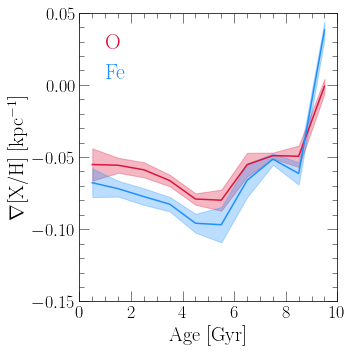

In [25]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Age [Gyr]")
ax.set_ylabel(r"$\nabla$[X/H] [kpc$^{-1}$]")
ax.set_xlim([0, 10])
ax.set_ylim([-0.15, 0.05])
ax.set_xticks(list(range(0, 11, 2)))
ax.set_yticks([-0.15, -0.10, -0.05, 0.0, 0.05])

# age_bins = list(range(11))
ages = [0.5 + i for i in range(10)]

kwargs = {
    "c": named_colors()["crimson"],
    "label": "O"
}
oh = [_[0] for _ in oh_slopes]
lower = [_[0] - _[1] for _ in oh_slopes]
upper = [_[0] + _[1] for _ in oh_slopes]
ax.plot(ages, oh, **kwargs)
kwargs["color"] = kwargs["c"]
del kwargs["c"]
kwargs["label"] = None
kwargs["alpha"] = 0.3
ax.fill_between(ages, lower, upper, **kwargs)

kwargs = {
    "c": named_colors()["dodgerblue"],
    "label": "Fe"
}
feh = [_[0] for _ in feh_slopes]
lower = [_[0] - _[1] for _ in feh_slopes]
upper = [_[0] + _[1] for _ in feh_slopes]
ax.plot(ages, feh, **kwargs)
kwargs["color"] = kwargs["c"]
del kwargs["c"]
kwargs["label"] = None
kwargs["alpha"] = 0.3
ax.fill_between(ages, lower, upper, **kwargs)

kwargs = {
    "loc": mpl_loc("upper left"),
    "handlelength": 0,
    "fontsize": 22
}
leg = ax.legend(**kwargs)
fancy_legend(leg, ["crimson", "dodgerblue"])

plt.tight_layout()
plt.savefig("../paper/figures/gradxh_vs_age.pdf")
plt.show()

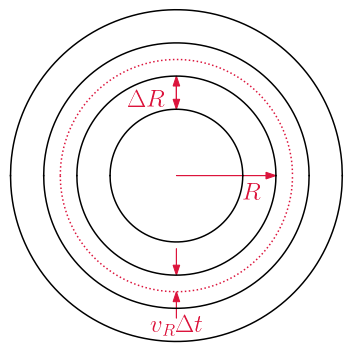

In [2]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlim([-5.1, 5.1])
ax.set_ylim([-5.1, 5.1])
ax.axis("off")

def plot_circle(radius, **kwargs):
    xvals = np.linspace(-radius, radius, 1000)
    yvals = [np.sqrt(radius**2 - x**2) for x in xvals]
    ax.plot(xvals, yvals, **kwargs)
    yvals = [-np.sqrt(radius**2 - x**2) for x in xvals]
    ax.plot(xvals, yvals, **kwargs)

kwargs = {"c": named_colors()["black"]}
for _ in [2, 3, 4, 5]: plot_circle(_, **kwargs)
plot_circle(3.5, c = named_colors()["crimson"], linestyle = ':')
kwargs = {
    "color": named_colors()["crimson"],
    "length_includes_head": True,
    "head_width": 0.2
}
ax.arrow(0, 0, 3, 0, **kwargs)
ax.arrow(0, 2, 0, 1, **kwargs)
ax.arrow(0, 3, 0, -1, **kwargs)
ax.arrow(0, -4.3, 0, 0.8, **kwargs)
ax.arrow(0, -2.2, 0, -0.8, **kwargs)
ax.text(-1.5, 2.1, r"$\Delta R$", color = kwargs["color"], fontsize = 25)
ax.text(2, -0.7, r"$R$", color = kwargs["color"], fontsize = 25)
ax.text(-0.8, -4.7, r"$v_R \Delta t$", color = kwargs["color"], fontsize = 25)

plt.tight_layout()
plt.savefig("../paper/figures/radialflows_schematic.pdf")
plt.show()

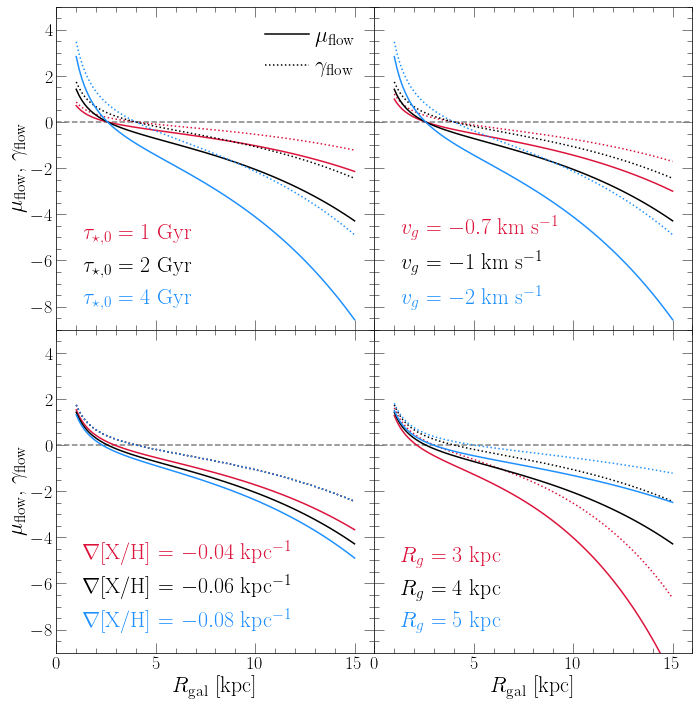

In [41]:
_SECONDS_PER_GYR_ = 3.1536e16
_KM_PER_KPC_ = 3.24e-17

def ralpha(A):
    r"""
    The e-folding scale radius of the metallicity gradient by mass.
    
    See :math:`R_\alpha` in notes above.
    """
    return -1 / (A * np.log(10))

def mu_flow(taustar, vr, A, rg, R):
    vr *= _SECONDS_PER_GYR_
    vr *= _KM_PER_KPC_ # vr now in kpc / Gyr
    return -taustar * vr * (1 / R - 1 / rg - 1 / ralpha(A))

def gamma_flow(taustar, vr, rg, R):
    vr *= _SECONDS_PER_GYR_
    vr *= _KM_PER_KPC_
    return -taustar * vr * (1 / R - 1 / rg)

def tau_star(radius, taustar0 = 2, Rg = 4, N = 1.5):
    return taustar0 * np.exp((N - 1) * radius / Rg)

fig = plt.figure(figsize = (10, 10))
axes = []
for i in range(4):
    kwargs = {}
    if i: kwargs["sharey"] = axes[0]
    axes.append(fig.add_subplot(221 + i, **kwargs))
    if i == 0 or i == 2:
        axes[i].set_ylabel(r"$\mu_\text{flow}$, $\gamma_\text{flow}$", fontsize = 22)
    else:
        plt.setp(axes[i].get_yticklabels(), visible = False)
    if i >= 2:
        axes[i].set_xlabel(r"$R_\text{gal}$ [kpc]", fontsize = 22)
    else:
        plt.setp(axes[i].get_xticklabels(), visible = False)
    axes[i].set_xlim([0, 16])
    axes[i].set_ylim([-9, 5])
    axes[i].axhline(0, c = named_colors()["grey"], linestyle = '--')
    
kwargs = {
    "c": named_colors()["black"],
    "label": r"$\mu_\text{flow}$",
    "linestyle": '-'
}
line1 = axes[0].plot([-10, -20], [-10, -20], **kwargs)[0]
kwargs["linestyle"] = ":"
kwargs["label"] = r"$\gamma_\text{flow}$"
line2 = axes[0].plot([-10, -20], [-10, -20], **kwargs)[0]
kwargs = {
    "loc": mpl_loc("upper right"),
    "fontsize": 22
}
leg = axes[0].legend(**kwargs)
axes[0].add_artist(leg)
line1.remove()
line2.remove()

colors = ["crimson", "black", "dodgerblue"]
taustar0 = [1, 2, 4]
vr = [-0.7, -1, -2]
A = [-0.04, -0.06, -0.08]
rg = [3, 4, 5]

xvals = np.linspace(1, 15, 100)

for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$\tau_{\star,0} = %g$ Gyr" % (taustar0[i]),
        "linestyle": "-"
    }
    yvals = [mu_flow(tau_star(x, taustar0 = taustar0[i]), vr[1], A[1], rg[1], x) for x in xvals]
    axes[0].plot(xvals, yvals, **kwargs)
    kwargs["linestyle"] = ":"
    kwargs["label"] = None
    yvals = [gamma_flow(tau_star(x, taustar0 = taustar0[i]), vr[1], rg[1], x) for x in xvals]
    axes[0].plot(xvals, yvals, **kwargs)
    
for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$v_g = %g$ km s$^{-1}$" % (vr[i]),
        "linestyle": "-"
    }
    yvals = [mu_flow(tau_star(x, taustar0 = taustar0[1]), vr[i], A[1], rg[1], x) for x in xvals]
    axes[1].plot(xvals, yvals, **kwargs)
    kwargs["linestyle"] = ":"
    kwargs["label"] = None
    yvals = [gamma_flow(tau_star(x, taustar0 = taustar0[1]), vr[i], rg[1], x) for x in xvals]
    axes[1].plot(xvals, yvals, **kwargs)
    
for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$\nabla$[X/H] = $%g$ kpc$^{-1}$" % (A[i]),
        "linestyle": "-"
    }
    yvals = [mu_flow(tau_star(x, taustar0 = taustar0[1]), vr[1], A[i], rg[1], x) for x in xvals]
    axes[2].plot(xvals, yvals, **kwargs)
    kwargs["linestyle"] = ":"
    kwargs["label"] = None
    yvals = [gamma_flow(tau_star(x, taustar0 = taustar0[1]), vr[1], rg[1], x) for x in xvals]
    axes[2].plot(xvals, yvals, **kwargs)

for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$R_g = %g$ kpc" % (rg[i]),
        "linestyle": "-"
    }
    yvals = [mu_flow(tau_star(x, taustar0 = taustar0[1], Rg = rg[i]), vr[1], A[1], rg[i], x) for x in xvals]
    axes[3].plot(xvals, yvals, **kwargs)
    kwargs["linestyle"] = ":"
    kwargs["label"] = None
    yvals = [gamma_flow(tau_star(x, taustar0 = taustar0[1], Rg = rg[i]), vr[1], rg[i], x) for x in xvals]
    axes[3].plot(xvals, yvals, **kwargs)

for i in range(4):
    kwargs = {
        "loc": mpl_loc("lower left"),
        "handlelength": 0,
        "fontsize": 22
    }
    leg = axes[i].legend(**kwargs)
    fancy_legend(leg, colors)

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0)
plt.savefig("../paper/figures/muflow_gammaflow_vs_radius.pdf")
plt.show()

In [3]:
outputs = [
#     "../outputs/inside-out/vrad0",
    "../outputs/simplified/const-with-eta",
    "../outputs/simplified/expsfh-eta0"
]
outputs = [vice.output(_) for _ in outputs]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:,-1]][:out.stars.size[0]]

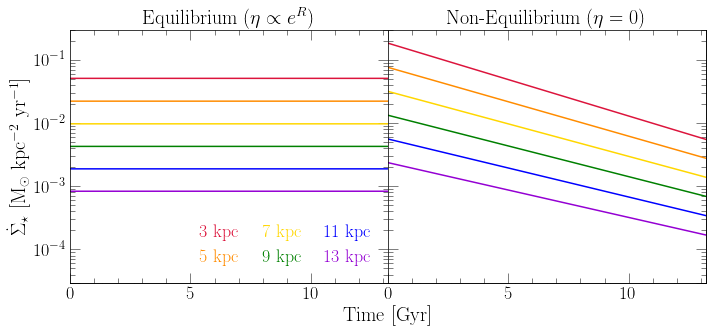

In [4]:
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex = ax1, sharey = ax1)
for ax in [ax1, ax2]:
    ax.set_yscale("log")
    ax.set_xlim([0, 13.2])
    ax.set_ylim([3.e-5, 0.3])
# ax1.set_title(r"$\eta \propto e^R$ ; Johnson et al. (2021)", fontsize = 20)
# ax2.set_title(r"$\eta = 0$ ; Simplified Example", fontsize = 20)
ax1.set_title(r"Equilibrium ($\eta \propto e^R$)", fontsize = 20)
ax2.set_title(r"Non-Equilibrium ($\eta = 0$)", fontsize = 20)
plt.setp(ax2.get_yticklabels(), visible = False)
ax1.set_ylabel(r"$\dot{\Sigma}_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
dummy = fig.add_subplot(111, zorder = -100)
plt.setp(dummy.get_xticklabels(), visible = False)
plt.setp(dummy.get_yticklabels(), visible = False)
pos = dummy.get_position()
pos.x0 = ax1.get_position().x0
pos.x1 = ax2.get_position().x1
pos.y0 = ax1.get_position().y0
pos.y1 = ax2.get_position().y1
dummy.set_position(pos)
dummy.set_xlabel("Time [Gyr]", labelpad = 20)

zone_width = 0.1
radii = [3, 5, 7, 9, 11, 13]
colors = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]

def plot_sfh(ax, output):
    for i, r in enumerate(radii):
        zone_idx = int(r / zone_width)
        zone = output.zones["zone%d" % (zone_idx)]
        area = np.pi * ((r + zone_width)**2 - r**2)
        sigma_sfr = [_ / area for _ in zone.history["sfr"]]
        kwargs = {
            "c": named_colors()[colors[i]],
            "label": "%d kpc" % (r)
        }
        ax.plot(zone.history["time"], sigma_sfr, **kwargs)

plot_sfh(ax1, outputs[0])
plot_sfh(ax2, outputs[1])

kwargs = {
    "loc": mpl_loc("lower right"),
    "handlelength": 0,
    "ncol": 3,
    "columnspacing": 1
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
plt.savefig("../paper/figures/simplified-examples-sfhs.pdf")
plt.show()

115465136.90988676
4.45830878758478


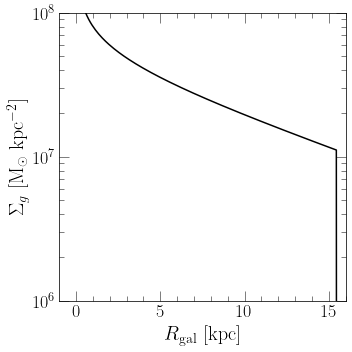

In [52]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
ax.set_ylabel(r"$\Sigma_g$ [M$_\odot$ kpc$^{-2}$]")
ax.set_xlim([-1, 16])
ax.set_ylim([1.e6, 1.e8])
ax.set_yscale("log")

output = outputs[1]
zone_width = 0.1
radii = [0.05 + zone_width * i for i in range(int(20 / zone_width))]
sigma_g = []
for i in range(len(radii)):
    area = np.pi * ((radii[i] + zone_width / 2)**2 - (radii[i] - zone_width / 2)**2)
    s = output.zones["zone%d" % (i)].history["mgas"][-1]
    s /= area
    sigma_g.append(s)
ax.plot(radii, sigma_g, c = named_colors()["black"])

def exponential(radius, norm, scale):
    return norm * np.exp(-radius / scale)

popt, pcov = curve_fit(exponential, radii, sigma_g, p0 = [3.e7, 6])
print(popt[0])
print(popt[1])

plt.tight_layout()
plt.show()

Computing MDF for R = 3 - 5 kpc....
Computing MDF for R = 5 - 7 kpc....
Computing MDF for R = 7 - 9 kpc....
Computing MDF for R = 9 - 11 kpc....
Computing MDF for R = 11 - 13 kpc....
Computing MDF for R = 13 - 15 kpc....
Computing MDF for R = 3 - 5 kpc....
Computing MDF for R = 5 - 7 kpc....
Computing MDF for R = 7 - 9 kpc....
Computing MDF for R = 9 - 11 kpc....
Computing MDF for R = 11 - 13 kpc....
Computing MDF for R = 13 - 15 kpc....


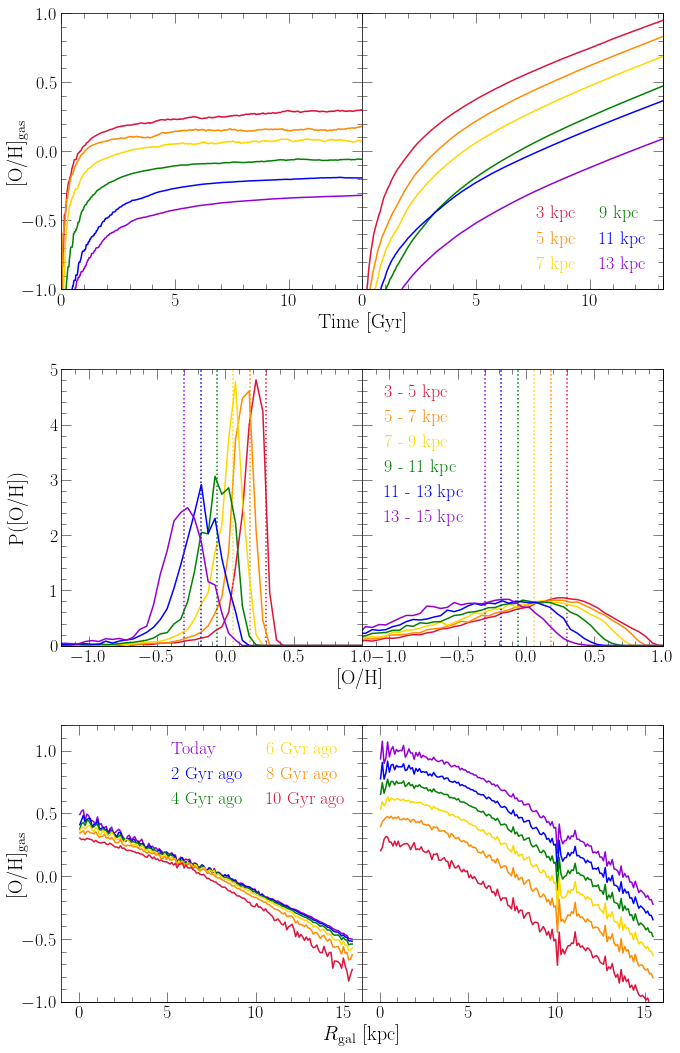

In [4]:
fig = plt.figure(figsize = (10, 15))
axes = []
for i in range(6):
    kwargs = {}
    if i % 2:
        kwargs["sharex"] = axes[i - 1]
        kwargs["sharey"] = axes[i - 1]
    else: pass
    axes.append(fig.add_subplot(321 + i, **kwargs))
    if i % 2: plt.setp(axes[i].get_yticklabels(), visible = False)
dummies = []
for i in range(3):
    kwargs = {"zorder": -100}
    dummies.append(fig.add_subplot(311 + i, **kwargs))
    plt.setp(dummies[i].get_xticklabels(), visible = False)
    plt.setp(dummies[i].get_yticklabels(), visible = False)
    pos = dummies[i].get_position()
    pos.x0 = axes[2 * i].get_position().x0
    pos.x1 = axes[2 * i + 1].get_position().x1
    pos.y0 = axes[2 * i].get_position().y0
    pos.y1 = axes[2 * i].get_position().y1
    dummies[i].set_position(pos)
dummies[0].set_xlabel("Time [Gyr]", labelpad = 20)
dummies[0].set_ylabel(r"[O/H]$_\text{gas}$", labelpad = 30)
dummies[1].set_xlabel("[O/H]", labelpad = 20)
dummies[1].set_ylabel("P([O/H])", labelpad = 30)
dummies[2].set_xlabel(r"$R_\text{gal}$ [kpc]", labelpad = 20)
dummies[2].set_ylabel(r"[O/H]$_\text{gas}$", labelpad = 30)
axes[0].set_xlim([0, 13.2])
axes[0].set_ylim([-1, 1])
axes[2].set_xlim([-1.2, 1])
axes[2].set_ylim([0, 5])
axes[4].set_xlim([-1, 16])
axes[4].set_ylim([-1, 1.2])

zone_width = 0.1
radii_colors = {
    3: "crimson",
    5: "darkorange",
    7: "gold",
    9: "green",
    11: "blue",
    13: "darkviolet"
}
lookback_colors = {
    0: "darkviolet",
    2: "blue",
    4: "green",
    6: "gold",
    8: "darkorange",
    10: "crimson"
}

def plot_oh_vs_time(ax, output):
    for r in radii_colors.keys():
        zone_idx = int(r / zone_width)
        zone = output.zones["zone%d" % (zone_idx)]
        kwargs = {
            "c": named_colors()[radii_colors[r]],
            "label": "%d kpc" % (r)
        }
        ax.plot(zone.history["time"], zone.history["[o/h]"], **kwargs)
        
def plot_mdf(ax, output):
    stars = output.stars.filter("absz", "<=", 0.5).filter("mass", ">", 1)
    radial_bins = list(radii_colors.keys()) + [15]
#     bins = output.zones["zone0"].mdf["bin_edge_left"] + [output.zones["zone0"].mdf["bin_edge_right"][-1]]
    bins = [-2 + 0.05 * i for i in range(81)]
    centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    for i in range(len(radial_bins) - 1):
        print("Computing MDF for R = %d - %d kpc...." % (radial_bins[i], radial_bins[i + 1]))
        kwargs = {
            "c": named_colors()[radii_colors[radial_bins[i]]],
            "linestyle": ":"
        }
#         target = -0.06 * ((radial_bins[i] + radial_bins[i + 1]) / 2 - 8)
        target = -0.06 * (radial_bins[i] - 8)
        ax.axvline(target, **kwargs)
        sub = stars.filter(
            "zone_final", ">=", int(radial_bins[i] / zone_width)).filter(
            "zone_final", "<=", int(radial_bins[i + 1] / zone_width - 1))
        dist, _ = np.histogram(sub["[o/h]"], bins = bins, weights = sub["mass"], density = True)
#         kwargs = {
#             "c": named_colors()[radii_colors[radial_bins[i]]],
#             "label": r"%d - %d kpc" % (radial_bins[i], radial_bins[i + 1])
#         }
        kwargs["linestyle"] = "-"
        kwargs["label"] = r"%d - %d kpc" % (radial_bins[i], radial_bins[i + 1])
        ax.plot(centers, dist, **kwargs)
        
def plot_gas_gradient(ax, output, lookbacktime):
    xvals = [zone_width / 2]
    while xvals[-1] + zone_width < 15.5: xvals.append(xvals[-1] + zone_width)
    yvals = []
    for i in range(len(xvals)):
        zone = output.zones["zone%d" % (i)]
        diff = [abs(lookbacktime - _) for _ in zone.history["lookback"]]
        idx = diff.index(min(diff))
        yvals.append(zone.history["[o/h]"][idx])
    kwargs = {
        "c": named_colors()[lookback_colors[lookbacktime]],
        "label": "%d Gyr ago" % (lookbacktime) if lookbacktime else "Today"
    }
    ax.plot(xvals, yvals, **kwargs)
    
plot_oh_vs_time(axes[0], outputs[0])
plot_oh_vs_time(axes[1], outputs[1])
plot_mdf(axes[2], outputs[0])
plot_mdf(axes[3], outputs[1])
for lookbacktime in lookback_colors.keys():
    plot_gas_gradient(axes[4], outputs[0], lookbacktime)
    plot_gas_gradient(axes[5], outputs[1], lookbacktime)
    
kwargs = {
    "loc": mpl_loc("lower right"),
    "ncol": 2,
    "handlelength": 0,
    "columnspacing": 1
}
leg = axes[1].legend(**kwargs)
fancy_legend(leg, [radii_colors[r] for r in radii_colors.keys()])

kwargs["loc"] = mpl_loc("upper left")
kwargs["ncol"] = 1
leg = axes[3].legend(**kwargs)
fancy_legend(leg, [radii_colors[r] for r in radii_colors.keys()])

kwargs["loc"] = mpl_loc("upper right")
kwargs["ncol"] = 2
leg = axes[4].legend(**kwargs)
fancy_legend(leg, [lookback_colors[l] for l in lookback_colors.keys()])

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
plt.savefig("../paper/figures/simplified-examples.pdf")
plt.show()

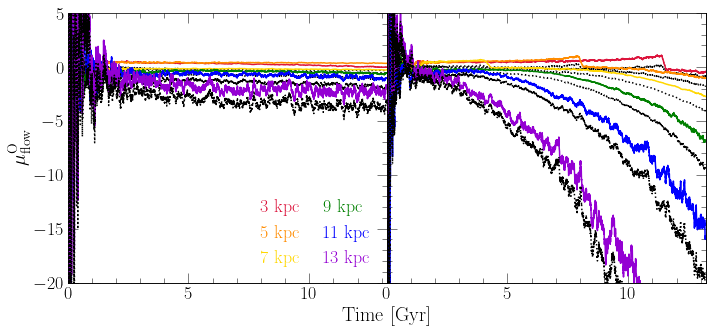

In [57]:
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharey = ax1)
for ax in [ax1, ax2]:
    ax.set_xlim([0, 13.2])
    ax.set_xticks([0, 5, 10])
plt.setp(ax2.get_yticklabels(), visible = False)
ax1.set_ylabel(r"$\mu_\text{flow}^\text{O}$")
ax1.set_ylim([-20, 5])
dummy = fig.add_subplot(111, zorder = -100)
plt.setp(dummy.get_xticklabels(), visible = False)
plt.setp(dummy.get_yticklabels(), visible = False)
dummy.set_xlabel(r"Time [Gyr]", labelpad = 20)
pos = dummy.get_position()
pos.x0 = ax1.get_position().x0
pos.x1 = ax2.get_position().x1
pos.y0 = ax1.get_position().y0
pos.y1 = ax1.get_position().y1
dummy.set_position(pos)

radii = [3, 5, 7, 9, 11, 13]
colors = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]
zone_width = 0.1
_SECONDS_PER_GYR_ = 3.1536e16
_KPC_PER_KM_ = 3.24e-17

def plot_muflow_vs_time(ax, radius, zone_output, outer_neighbor, flow_velocity, **kwargs):
    flow_velocity *= _SECONDS_PER_GYR_ * _KPC_PER_KM_
    area = np.pi * ((radius + zone_width)**2 - radius**2)
    neighbor_area = np.pi * ((radius + zone_width)**2 - radius**2)
    sigma_gas = [_ / area for _ in zone_output.history["mgas"]]
    sigma_sfr = [_ / area for _ in zone_output.history["sfr"]]
    neighbor_sigma_gas = [_ / neighbor_area for _ in outer_neighbor.history["mgas"]]
    tau_star = [1.e-9 * gas / sfr if sfr else float("nan") for gas, sfr in zip(sigma_gas, sigma_sfr)]
    prefactor = [-_ * flow_velocity for _ in tau_star]
    pileup_term = [_ / radius for _ in prefactor]
    dlnsigmag_dr = [(inner - outer) / (inner * zone_width) if inner else float("nan") for outer, inner in zip(
        neighbor_sigma_gas, sigma_gas)]
    dlnz_dr = [(inner - outer) / (inner * zone_width) if inner else float("nan") for outer, inner in zip(
        zone_output.history["z(o)"], outer_neighbor.history["z(o)"])]
    gasgradient_term = [pre * gas for pre, gas in zip(prefactor, dlnsigmag_dr)]
    zgradient_term = [pre * z for pre, z in zip(prefactor, dlnz_dr)]
    mu_flow = [pileup + gas + z for pileup, gas, z in zip(pileup_term, gasgradient_term, zgradient_term)]
    
    ax.plot(zone_output.history["time"], mu_flow, **kwargs)
    kwargs["c"] = named_colors()["black"]
    kwargs["linestyle"] = ":"
    kwargs["label"] = None
    ax.plot(zone_output.history["time"], zgradient_term, **kwargs)
    
for i, out in enumerate(outputs):
    for j, r in enumerate(radii):
        inner = out.zones["zone%d" % (int(r / zone_width))]
        outer = out.zones["zone%d" % (int(r / zone_width + 1))]
        plot_muflow_vs_time([ax1, ax2][i], r, inner, outer, -1,
            c = colors[j], label = r"%d kpc" % (r))
        
kwargs = {
    "loc": mpl_loc("lower right"),
    "handlelength": 0,
    "ncol": 2,
    "columnspacing": 1
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
plt.show()

In [3]:
_SECONDS_PER_GYR_ = 3.1536e16 # conversion factor
_KM_PER_KPC_ = 3.24e-17 # conversion factor
taudisk = 13.2

class risefall_zalpha:
    
    def __init__(self, radius, taurise = 2, tausfh = 6, yieldsolar = 2, gradient = -0.06, vr = 0,
        eta = 0, taustar0 = 2, Rg = 3, N = 1.5, recycling = 0.4):
        self.radius = radius
        self.taurise = taurise
        self.tausfh = tausfh
        self.yalpha = yieldsolar * vice.solar_z['o']
        self.ralpha = -(np.log(10) * gradient)**(-1)
        self.eta = eta
        self.taustar = taustar0 * np.exp((N - 1) * self.radius / Rg)
        vr *= _SECONDS_PER_GYR_ * _KM_PER_KPC_
        self.muflow = vr * self.taustar * (1 / radius - 1 / Rg - 1 / self.ralpha)
        self.recycling = 0.4
        
    def __call__(self, time):
        # tau mu same as tau_eq above, though denoted differently here as for this SFH is does not
        # denote the timescale on which the ISM reaches equilibrium.
        if time == 0: return 0
        taumu = ((1 + self.eta - self.recycling - self.muflow) / self.taustar - 1 / self.tausfh)**(-1)
        zeq = self.yalpha * taumu / self.taustar
        prefactor = 1 - np.exp(-time / taumu)
        prefactor -= self.taurise / (self.taurise - taumu) * (
            np.exp(-time / self.taurise) - np.exp(-time / taumu))
        prefactor /= 1 - np.exp(-time / self.taurise)
        return zeq * prefactor
    
    @property
    def equilibrium(self):
        r"""The equilibrium abundance"""
        taumu = ((1 + self.eta - self.recycling - self.muflow) / self.taustar - 1 / self.tausfh)**(-1)
        return self.yalpha / taumu / self.taustar
    
#     @staticmethod
#     def eq_ratio(radius, taudisk = 13.2, taurise = 2, tausfh = 6, yieldsolar = 2, gradient = -0.06,
#         vr = 0, eta = 0, taustar0 = 2, Rg = 2, N = 1.5, recycling = 0.4):        
#         ralpha = -(np.log(10) * gradient)**(-1)
#         taustar = taustar0 * np.exp((N - 1) * radius / Rg)
#         vr *= _SECOND_PER_GYR_ * _KM_PER_KPC_
#         muflow = vr * taustar * (1 / radius - 1 / Rg - 1 / ralpha)
#         taumu = (1 + eta - r - muflow)

    @staticmethod
    def eq_ratio(radius, **kwargs):
        defaults = {
            "taudisk": 13.2,
            "taurise": 2,
            "tausfh": 6,
            "yieldsolar": 2,
            "gradient": -0.06,
            "vr": 0,
            "eta": 0,
            "taustar0": 2,
            "Rg": 3,
            "N": 1.5,
            "recycling": 0.4
        }
        for key in kwargs.keys(): defaults[key] = kwargs[key]
        yalpha = defaults["yieldsolar"] * vice.solar_z['o']
        taustar = defaults["taustar0"] * np.exp((defaults["N"] - 1) * radius / defaults["Rg"])
        zeq = yalpha / (1 + defaults["eta"] - defaults["recycling"] - taustar / defaults["tausfh"])
#         return zeq
        ratio = risefall_zalpha.at_present_day(radius, **kwargs) / zeq
#         if ratio > 1: print(ratio)
        return ratio

    @staticmethod
    def at_present_day(radius, taudisk = 13.2, taurise = 2, tausfh = 6, yieldsolar = 2, gradient = -0.06,
        vr = 0, eta = 0, taustar0 = 2, Rg = 3, N = 1.5, recycling = 0.4):
        yalpha = yieldsolar * vice.solar_z['o']
        ralpha = -(np.log(10) * gradient)**(-1)
        taustar = taustar0 * np.exp((N - 1) * radius / Rg)
        vr *= _SECONDS_PER_GYR_ * _KM_PER_KPC_
        muflow = vr * taustar * (1 / radius - 1 / Rg - 1 / ralpha)
        taumu = ((1 + eta - recycling - muflow) / taustar - 1 / tausfh)**(-1)
        zeq = yalpha * taumu / taustar
        prefactor = 1 - np.exp(-taudisk / taumu)
        prefactor -= taurise / (taurise - taumu) * (np.exp(-taudisk / taurise) - np.exp(-taudisk / taumu))
        prefactor /= 1 - np.exp(-taudisk / taurise)
        result = zeq * prefactor
        if result < 0: print(result)
        return result
    
    @staticmethod
    def percentile(N, taudisk = 13.2, taurise = 2, tausfh = 6):
        def fsfh(t):
            return (1 - np.exp(-t / taurise)) * np.exp(-t / tausfh)
        def driver(taun):
            term1 = quad(fsfh, taudisk - taun, taudisk)[0]
            term2 = N / 100 * quad(fsfh, 0, taudisk)[0]
            return term1 - term2
        return bisect(driver, 0, taudisk)
    
    @staticmethod
    def gradient(radius, slope = -0.06):
        ralpha = -(np.log(10) * slope)**(-1)
        return vice.solar_z['o'] * np.exp(-(radius - 8) / ralpha)

In [4]:
taudisk = 13.2

_DEFAULT_KWARGS_ = {
    "gradient": -0.06,
    "yieldsolar": 2,
    "vr": 0,
    "eta": 0,
    "taustar0": 2,
    "Rg": 3,
    "N": 1.5,
    "recycling": 0.4
}
_KWARGS_ = _DEFAULT_KWARGS_.copy()

def find_tausfh_driver(tausfh, radius, taurise):
    diff = risefall_zalpha.at_present_day(radius, tausfh = tausfh, taurise = taurise, **_KWARGS_)
    diff -= risefall_zalpha.gradient(radius, slope = _KWARGS_["gradient"])
    return diff

def find_taurise_driver(taurise, radius, tausfh):
    diff = risefall_zalpha.at_present_day(radius, tausfh = tausfh, taurise = taurise, **_KWARGS_)
    diff -= risefall_zalpha.gradient(radius, slope = _KWARGS_["gradient"])
    return diff

def find_tausfh_taurise(radius, **kwargs):
    for key in _DEFAULT_KWARGS_.keys():
        if key in kwargs.keys():
            _KWARGS_[key] = kwargs[key]
        else:
            _KWARGS_[key] = _DEFAULT_KWARGS_[key]
    taurise = 2
    tausfhmax = 200
    if (find_tausfh_driver(0.1, radius, taurise) *
        find_tausfh_driver(tausfhmax, radius, taurise) < 0):
        tausfh = bisect(find_tausfh_driver, 0.1, tausfhmax, args = (radius, taurise))
        return [tausfh, taurise]
    elif (find_taurise_driver(0.1, radius, tausfhmax) *
        find_taurise_driver(2 * taudisk, radius, tausfhmax) < 0):
        taurise = bisect(find_taurise_driver, 0.1, 2 * taudisk, args = (radius, tausfhmax))
        return [tausfhmax, taurise]
    else:
        return [float("nan"), float("nan")]

In [5]:
def compute_median_ages(values, keywordarg, filename_stem):
    radii = [0.05 + 0.1 * i for i in range(200)]
    for i in range(len(values)):
        kwargs = {
            keywordarg: values[i],
            "yieldsolar": yieldsolar
        }
        raw = [find_tausfh_taurise(_, **kwargs) for _ in radii]
        tausfh = [_[0] for _ in raw]
        taurise = [_[1] for _ in raw]
        yvals = [risefall_zalpha.percentile(50, tausfh = _[0], taurise = _[1]) for _ in raw]
        filename = "%s_%.2f.out" % (filename_stem, values[i])
        np.savetxt(filename, list(zip(radii, tausfh, taurise, yvals)), fmt = "%.3e")

In [6]:
yieldsolar = 2
warnings.filterwarnings("ignore")

Rg_values = [2, 2.3, 2.7, 3, 3.3, 3.7, 4]
taustar0_values = [1, 1.5, 2, 2.5, 3]
eta_values = [0, 0.5, 1, 1.5, 2, 2.5, 3]
slopes = [-0.02, -0.03, -0.04, -0.05, -0.06, -0.07, -0.08, -0.09, -0.10]
indeces = [0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1]
velocities = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]

compute_median_ages(Rg_values, "Rg", "./paperfigures/medages_rg")
compute_median_ages(taustar0_values, "taustar0", "./paperfigures/medages_taustar0")
compute_median_ages(eta_values, "eta", "./paperfigures/medages_eta")
compute_median_ages(slopes, "gradient", "./paperfigures/medages_gradient")
compute_median_ages(indeces, "N", "./paperfigures/medages_N")
compute_median_ages(velocities, "vr", "./paperfigures/medages_vr")

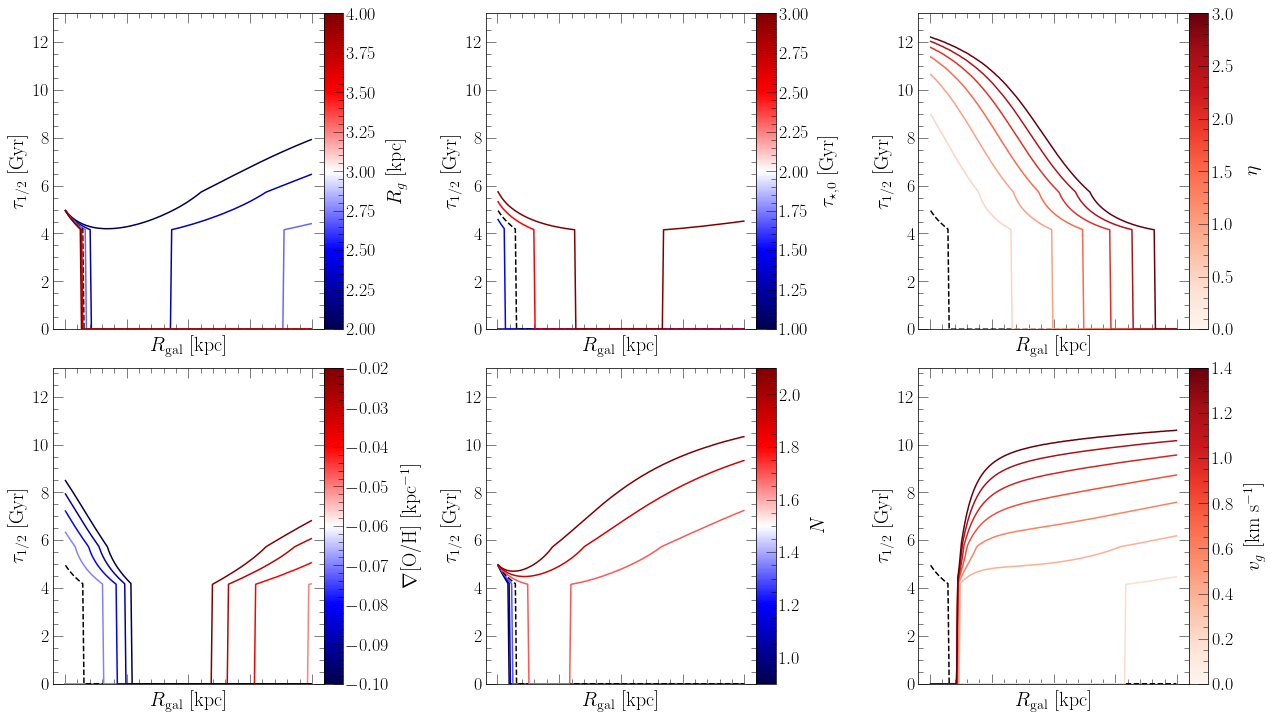

In [7]:
fig = plt.figure(figsize = (18, 10))
axes = []
for i in range(6):
    axes.append(fig.add_subplot(231 + i))
    axes[i].set_xlabel(r"$R_\text{gal}$ [kpc]")
    axes[i].set_ylabel(r"$\tau_{1/2}$ [Gyr]")
    axes[i].set_ylim([0, 13.2])
    axes[i].set_yticks([0, 2, 4, 6, 8, 10, 12])
    axes[i].yaxis.set_major_formatter(fsf("%g"))
    plt.setp(axes[i].get_xticklabels(), visible = False)
plt.tight_layout()
plt.subplots_adjust(wspace = 0.6, right = 0.92)

def plot_behavior(ax, values, fiducial, filenamestem, label, colormap):
    for i in range(len(values)):
        raw = np.genfromtxt("%s_%.2f.out" % (filenamestem, values[i]))
        radii = [_[0] for _ in raw]
        medages = [_[-1] for _ in raw]
        kwargs = {}
        if values[i] == fiducial:
            kwargs["c"] = named_colors()["black"]
            kwargs["linestyle"] = "--"
        else:
            cm = plt.get_cmap(colormap)
            cnorm = mplcolors.Normalize(vmin = min(values), vmax = max(values))
            sc = cmx.ScalarMappable(norm = cnorm, cmap = cm)
            kwargs["c"] = sc.to_rgba(values[i])
        ax.plot(radii, medages, **kwargs)
    cbar_ax = fig.add_axes([0.92, 0.05, 0.02, 0.95])
    cbar = plt.colorbar(sc, cax = cbar_ax, pad = 0, orientation = "vertical")
    cbar.set_label(label, labelpad = 10)
    cbar_ax.set_position([
        ax.get_position().x1,
        ax.get_position().y0,
        0.015,
        ax.get_position().y1 - ax.get_position().y0
    ])

Rg_values = [2, 2.3, 2.7, 3, 3.3, 3.7, 4]
taustar0_values = [1, 1.5, 2, 2.5, 3]
eta_values = [0, 0.5, 1, 1.5, 2, 2.5, 3]
slopes = [-0.02, -0.03, -0.04, -0.05, -0.06, -0.07, -0.08, -0.09, -0.10]
indeces = [0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1]
velocities = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]

plot_behavior(axes[0], Rg_values, 3, "./paperfigures/medages_rg", r"$R_g$ [kpc]", "seismic")
plot_behavior(axes[1], taustar0_values, 2, "./paperfigures/medages_taustar0", r"$\tau_{\star,0}$ [Gyr]", "seismic")
plot_behavior(axes[2], eta_values, 0, "./paperfigures/medages_eta", r"$\eta$", "Reds")
plot_behavior(axes[3], slopes, -0.06, "./paperfigures/medages_gradient", r"$\nabla$[O/H] [kpc$^{-1}$]", "seismic")
plot_behavior(axes[4], indeces, 1.5, "./paperfigures/medages_N", r"$N$", "seismic")
plot_behavior(axes[5], velocities, 0, "./paperfigures/medages_vr", "$v_g$ [km s$^{-1}$]", "Reds")

# plt.savefig("../paper/figures/medage_inputparams.pdf")
plt.show()

In [66]:
outputs = [
    "../outputs/inside-out/vrad3",
    "../outputs/test-vrad1"
#     "../outputs/subequilibrium/vrad0"
]
outputs = [vice.output(_) for _ in outputs]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:,-1]][:out.stars.size[0]]

Age = 9 - 10 Gyr        


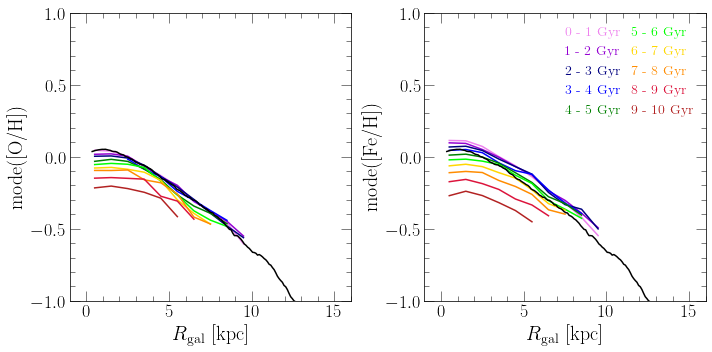

In [65]:
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for ax in [ax1, ax2]:
    ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
    ax.set_xlim([-1, 16])
    ax.set_ylim([-1, 1])
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax1.set_ylabel("mode([O/H])")
ax2.set_ylabel("mode([Fe/H])")

zone_width = 0.1
radial_bins = list(range(16))
age_bins = list(range(11))
colors = ["violet", "darkviolet", "navy", "blue", "green", "lime", "gold", "darkorange", "crimson", "firebrick"]

def plot_gradient_binned_by_age(oh_ax, feh_ax, output):
    centers = [(a + b) / 2 for a, b in zip(radial_bins[:-1], radial_bins[1:])]
    sub_midplane = output.stars.filter(
        "absz", "<=", 0.5).filter(
        "mass", ">", 1)
    for i in range(len(age_bins) - 1):
        sys.stdout.write("\rAge = %d - %d Gyr        " % (age_bins[i], age_bins[i + 1]))
        sub_age = sub_midplane.filter(
            "age", ">=", age_bins[i]).filter(
            "age", "<=", age_bins[i + 1])
        mode_oh = []
        mode_feh = []
        for j in range(len(radial_bins) - 1):
            sub = sub_age.filter(
                "zone_final", ">=", int(radial_bins[j] / zone_width)).filter(
                "zone_final", "<=", int(radial_bins[j + 1] / zone_width - 1))
            try:
                value = skewnormal_mode_sample(sub["[o/h]"])
                if value < 1:
                    mode_oh.append(value)
                else:
                    mode_oh.append(float("nan"))
            except:
                mode_oh.append(float("nan"))
            try:
                value = skewnormal_mode_sample(sub["[fe/h]"])
                if value < 1:
                    mode_feh.append(value)
                else:
                    mode_feh.append(float("nan"))
            except:
                mode_feh.append(float("nan"))
        kwargs = {
            "c": named_colors()[colors[i]],
            "label": "%d - %d Gyr" % (age_bins[i], age_bins[i + 1])
        }
        oh_ax.plot(centers, mode_oh, **kwargs)
        feh_ax.plot(centers, mode_feh, **kwargs)
    sys.stdout.write("\n")
    
def overlay_gas_phase_gradient(oh_ax, feh_ax, output):
    radii = [0.35 + 0.1 * i for i in range(152)]
    oh = []
    feh = []
    for i in range(len(radii)):
        zone = output.zones["zone%d" % (i + 3)]
        oh.append(zone.history["[o/h]"][-1])
        feh.append(zone.history["[o/h]"][-1])
    kwargs = {
        "c": named_colors()["black"],
        "linestyle": "-"
    }
    oh_ax.plot(radii, oh, **kwargs)
    feh_ax.plot(radii, feh, **kwargs)

plot_gradient_binned_by_age(ax1, ax2, outputs[1])
overlay_gas_phase_gradient(ax1, ax2, outputs[1])

kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 0,
    "ncol": 2,
    "columnspacing": 0.5,
    "fontsize": 14
}
leg = ax2.legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
# plt.savefig("../paper/figures/grad-agebins-calibrated-vrad0.pdf")
# plt.savefig("../paper/figures/grad-agebins-insideout-vrad1.pdf")
plt.show()

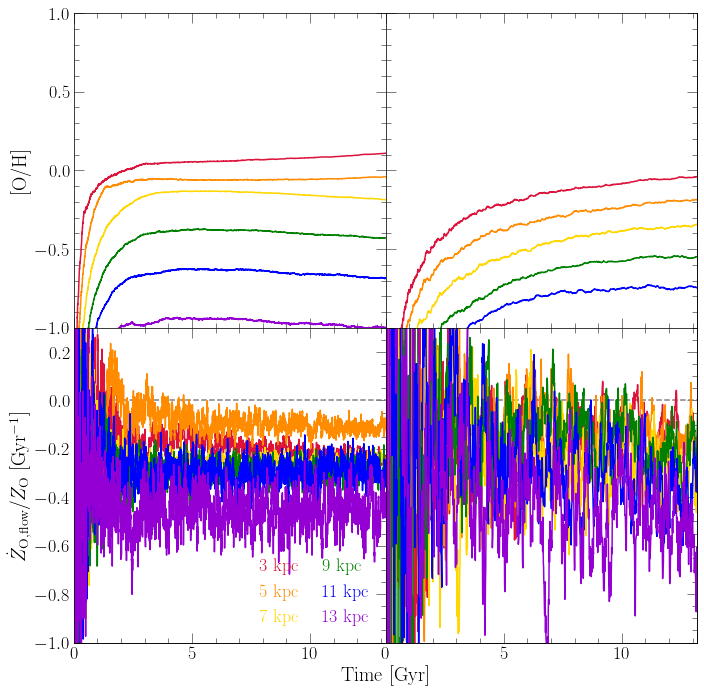

In [67]:
fig = plt.figure(figsize = (10, 10))
axes = []
for i in range(4):
    kwargs = {}
    if i % 2: kwargs["sharey"] = axes[i - 1]
    if i: kwargs["sharex"] = axes[0]
    axes.append(fig.add_subplot(221 + i, **kwargs))
    if i % 2: plt.setp(axes[i].get_yticklabels(), visible = False)
    if i < 2: plt.setp(axes[i].get_xticklabels(), visible = False)
dummy = fig.add_subplot(111, zorder = -100)
plt.setp(dummy.get_xticklabels(), visible = False)
plt.setp(dummy.get_yticklabels(), visible = False)
pos = dummy.get_position()
pos.x0 = axes[0].get_position().x0
pos.x1 = axes[1].get_position().x1
pos.y0 = axes[2].get_position().y0
pos.y1 = axes[0].get_position().y1
dummy.set_position(pos)
dummy.set_xlabel(r"Time [Gyr]", labelpad = 20)
axes[0].set_ylabel(r"[O/H]")
axes[2].set_ylabel(r"$\dot{Z}_\text{O,flow} / Z_\text{O}$ [Gyr$^{-1}$]")
axes[0].set_xlim([0, 13.2])
axes[0].set_ylim([-1, 1])
axes[0].set_yticks([-1, -0.5, 0, 0.5, 1])
axes[2].set_ylim([-1, 0.3])
for ax in axes[-2:]:
    ax.axhline(0, c = named_colors()["grey"], linestyle = "--")

zone_width = 0.1
_SECONDS_PER_GYR_ = 3.1536e16
_KM_PER_KPC_ = 3.24e-17

def plot_oh_vs_time(ax, zone_output, **kwargs):
    ax.plot(zone_output.history["time"], zone_output.history["[o/h]"], **kwargs)
    
def plot_zdotflow_vs_time(ax, zone_output, outer_neighbor, velocity, **kwargs):
    velocity *= _SECONDS_PER_GYR_ * _KM_PER_KPC_
    rates = []
    for i in range(len(zone_output.history["time"])):
        if zone_output.history["z(o)"][i]:
            rates.append((outer_neighbor.history["z(o)"][i] -
                zone_output.history["z(o)"][i]) / zone_width)
            rates[-1] *= -velocity / zone_output.history["z(o)"][i]
        else:
            rates.append(float("nan"))
    ax.plot(zone_output.history["time"], rates, **kwargs)
    
radii = [3, 5, 7, 9, 11, 13]
colors = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]
for i in range(len(radii)):
    for j, out in enumerate(outputs):
        kwargs = {
            "c": named_colors()[colors[i]],
            "label": "%d kpc" % (radii[i])
        }
        idx = int(radii[i] / zone_width)
        zone = out.zones["zone%d" % (idx)]
        neighbor = out.zones["zone%d" % (idx + 1)]
        plot_oh_vs_time(axes[j], zone, **kwargs)
        plot_zdotflow_vs_time(axes[2 + j], zone, neighbor, -1, **kwargs)
        
kwargs = {
    "loc": mpl_loc("lower right"),
    "ncol": 2,
    "handlelength": 0,
    "columnspacing": 1
}
leg = axes[2].legend(**kwargs)
fancy_legend(leg, colors)

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0)
plt.show()